Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.12.175:5001/ (Press CTRL+C to quit)
192.168.12.175 - - [26/Mar/2024 08:07:49] "GET / HTTP/1.1" 200 -
192.168.12.175 - - [26/Mar/2024 08:07:49] "GET /static/script.js HTTP/1.1" 200 -
192.168.12.175 - - [26/Mar/2024 08:07:49] "GET /static/backgrounds/sky.jpg HTTP/1.1" 200 -
Starting updateTable function
User input is: 310
Updated temp to 310
User input is: 42.3
Updated rpm to 42.3
User input is: 0.029
Updated growthRate to 0.029
User input is: 1000
Updated mediumDensity to 1000
User input is: 7
Updated doublings to 7
Found 1 documents
192.168.12.175 - - [26/Mar/2024 08:07:51] "POST /updateTable HTTP/1.1" 200 -


temp inputTemp 310
rpm inputRPM 42.3
growthRate inputGrowthRate 0.029
mediumDensity inputMediumDensity 1000
doublings inputDoublings 7


Starting updateTable function
User input is: 310
Updated temp to 310
User input is: 42.3
Updated rpm to 42.3
User input is: 0.029
Updated growthRate to 0.029
User input is: 1000
Updated mediumDensity to 1000
User input is: 7
Updated doublings to 7
Found 1 documents
192.168.12.175 - - [26/Mar/2024 08:07:56] "POST /updateTable HTTP/1.1" 200 -


temp inputTemp 310
rpm inputRPM 42.3
growthRate inputGrowthRate 0.029
mediumDensity inputMediumDensity 1000
doublings inputDoublings 7


Starting updateTable function
User input is: 310
Updated temp to 310
User input is: 42.3
Updated rpm to 42.3
User input is: 0.029
Updated growthRate to 0.029
User input is: 1000
Updated mediumDensity to 1000
User input is: 7
Updated doublings to 7
Found 1 documents
192.168.12.175 - - [26/Mar/2024 08:07:58] "POST /updateTable HTTP/1.1" 200 -


temp inputTemp 310
rpm inputRPM 42.3
growthRate inputGrowthRate 0.029
mediumDensity inputMediumDensity 1000
doublings inputDoublings 7


Starting updateTable function
User input is: 328
Updated temp to 328
User input is: 42.3
Updated rpm to 42.3
User input is: 0.029
Updated growthRate to 0.029
User input is: 1000
Updated mediumDensity to 1000
User input is: 7
Updated doublings to 7
No documents found with given params. Running simulation from scratch.
192.168.12.175 - - [26/Mar/2024 08:08:03] "POST /updateTable HTTP/1.1" 200 -
192.168.12.175 - - [26/Mar/2024 08:08:03] "GET /check-simulation-status HTTP/1.1" 200 -


temp inputTemp 328
rpm inputRPM 42.3
growthRate inputGrowthRate 0.029
mediumDensity inputMediumDensity 1000
doublings inputDoublings 7


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
locator: <matplotlib.ticker.FixedLocator object at 0x7f915a7d7310>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916b79c3a0>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916b924be0>
locator: <matplotlib.ticker.FixedLocator object at 0x7f91591af790>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916bad1e80>
locator: <matplotlib.ticker.FixedLocator object at 0x7f91591f3700>


Document inserted with ID: 6602e4d7fcc4d9df42afa0d1


192.168.12.175 - - [26/Mar/2024 08:08:08] "GET /check-simulation-status HTTP/1.1" 200 -
Starting updateTable function
User input is: 3444
Updated temp to 3444
User input is: 42.3
Updated rpm to 42.3
User input is: 0.029
Updated growthRate to 0.029
User input is: 1000
Updated mediumDensity to 1000
User input is: 7
Updated doublings to 7
No documents found with given params. Running simulation from scratch.
192.168.12.175 - - [26/Mar/2024 08:08:19] "POST /updateTable HTTP/1.1" 200 -
192.168.12.175 - - [26/Mar/2024 08:08:19] "GET /check-simulation-status HTTP/1.1" 200 -


temp inputTemp 3444
rpm inputRPM 42.3
growthRate inputGrowthRate 0.029
mediumDensity inputMediumDensity 1000
doublings inputDoublings 7


locator: <matplotlib.ticker.FixedLocator object at 0x7f916b963d30>
locator: <matplotlib.ticker.FixedLocator object at 0x7f915a8288b0>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916c09c250>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916c111e50>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916c19f640>
locator: <matplotlib.ticker.FixedLocator object at 0x7f916c2280d0>


Document inserted with ID: 6602e4e7fcc4d9df42afa0d2


192.168.12.175 - - [26/Mar/2024 08:08:24] "GET /check-simulation-status HTTP/1.1" 200 -


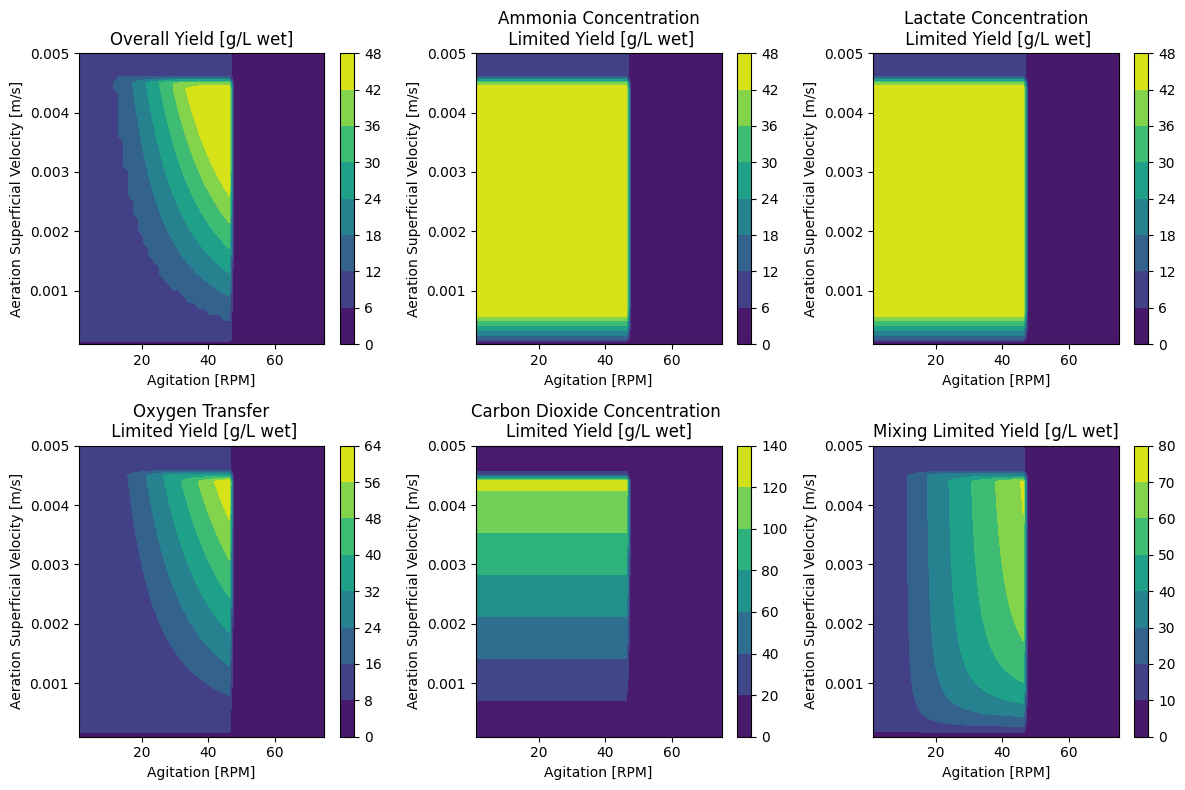

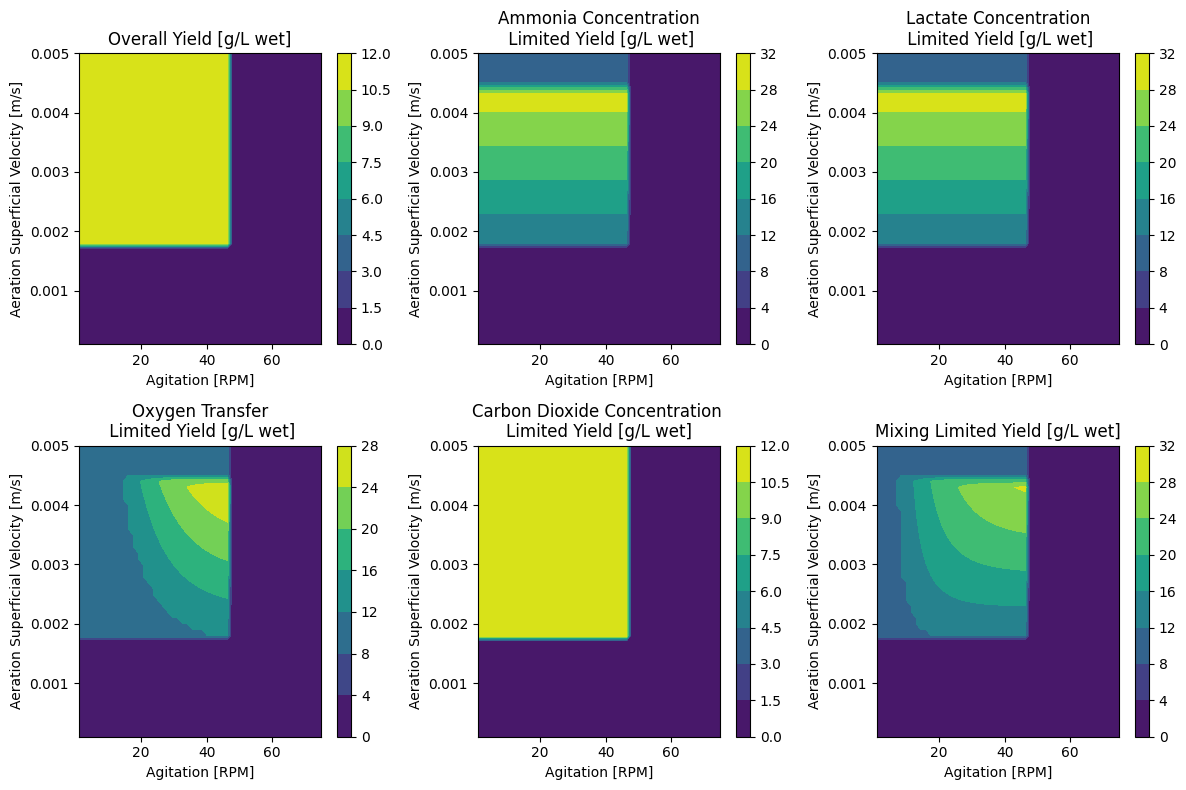

In [1]:
from flask import Flask, render_template, request, session, jsonify
from pymongo import MongoClient
import pandas as pd
import logging
from IPython.display import display, HTML
import base64
import os
import import_ipynb
import pipeline
from threading import Thread


logging.getLogger('matplotlib.font_manager').disabled = True

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create a StreamHandler to display log messages in the notebook
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

app = Flask(__name__)
app.secret_key = os.environ.get('SECRET_KEY', 'default_secret_key')

# Create a MongoDB client and connect to database
client = MongoClient("mongodb://localhost:27017/")
db = client["sims"]
collection = db["table1"]

@app.after_request
def addCacheHeaders(response):
    response.headers['Cache-Control'] = 'no-store'
    return response

# Define the 'inputs' dictionary within the session
def initSessionInputs():
    return {
        'workingVolume': 20000,
        'tankDiameter':  2.34,
        'rpm': 42.3,
        'backPressure': 1.3,
        'superficialVel': 0.004,
        'moleFracO2': 0.21,
        'moleFracCO2':  0.03,
        'initCells': 4e6,
        'temp': 310,
        'powerNumber': 5,
        'mediumDensity': 1000,
        'mediumViscosity': 9e-4,
        'vesselVolDay': 0.0,
        'perfLactateRate': 5.0,
        'perfAmmrate': 5.0,
        'growthRate': 0.029,
        'glutamineUptakeRate': 0,
        'glucoseUptakeRate': 0,
        'oxygenUptakeRate': 0.49, 
        'carbonDioxideProdRate': 0.593,
        'ammoniaProductionRate': 0.013571,
        'lactateProductionRate': 0.135707, 
        'massDensity': 1030,
        'cellRadius': 18e-6,
        'wetmass': 3000,
        'dryMassFraction': 0.3,
        'ammoniaLimit': 5,
        'lactateLimit': 50, 
        'CO2Limit': 100,
        'turbLengthLimit': 20e-6,
        'count': 50,
        'doublings': 7,
        'rpmlims': (1,75),
        'supervellims': (0.0001,0.005),
        'celldenslims': (5.9e5,6.1e5)
    }

@app.route('/updateTable', methods=['POST'])
def updateTable():
    # Retrieve session inputs
    logging.debug("Starting updateTable function")
    if 'inputs' not in session:
        session['inputs'] = initSessionInputs()

    inputs = session['inputs']

    # Get updated input params from user
    inputIDs = [('temp', 'inputTemp'), 
                   ('rpm', 'inputRPM'),
                   ('growthRate', 'inputGrowthRate'), 
                   ('mediumDensity', 'inputMediumDensity'),
                   ('doublings', 'inputDoublings')]
    for inputID in inputIDs:
        inputs = updateInput(inputs, inputID)

    # Build query using MongoDb syntax
    # Example: query['inputs.temp'] = 100
    query = {}
    for k, v in inputs.items():
        query['inputs.' + k] = v

    documentCount = collection.count_documents(query)
    if documentCount > 0:
        logging.debug("Found %s documents", documentCount)
        firstItem = collection.find_one(query)
        outputsData = firstItem['outputs']
        df = pd.DataFrame(outputsData.items(), columns=['Constraint', 'Maximum Yield [g/L wet]'])
        tableHtml = df.to_html(classes='table table-striped', index=False)
        
        # Retrieve graphs
        image_binary = firstItem['graph']
        image_base64 = base64.b64encode(image_binary).decode('utf-8')
        response_data = {
            'tableHtml': tableHtml,
            'graphData': 'data:image/png;base64,' + image_base64
        }

        return jsonify(response_data)
    else:
        logging.debug("No documents found with given params. Running simulation from scratch.")
        # Return a response indicating the simulation is starting
        pipeline.simulation_complete = False
        pipeline.table_html = None
        pipeline.graph_data = None

        # Run the simulation asynchronously
        Thread(target=pipeline.runSimAndInsert, args=(inputs,)).start()
        return jsonify({'status': 'running'})

def updateInput(inputs, inputID):
    name = inputID[0]
    _id = inputID[1]
    userInput = request.form.get(name)
    print(name, _id, userInput)
    logging.debug("User input is: %s", userInput)
    if userInput is not None:
        if userInput.isdigit():
            newValue = int(userInput)
        else:
            newValue = float(userInput)
            
        inputs[name] = newValue
        logging.debug("Updated %s to %s", name, newValue)
    
    return inputs
    
@app.route('/', methods=['GET'])
def index():
    return render_template('index.html', table='')
        
@app.route('/items')
def displayItems():
    items = collection.find()
    return render_template('items.html', items=items)

@app.route('/about')
def about():
    return render_template('about.html')

@app.route('/clear-session')
def clear_session_route():
    session.clear()
    return 'Session cleared'

@app.route('/check-simulation-status')
def check_simulation_status():
    # Check the status of the simulation
    if pipeline.simulation_complete:
        # If the simulation is complete, retrieve the results
        tableHtml = pipeline.get_table_html()
        graphData = pipeline.get_graph_data()
        return jsonify({'status': 'complete', 'tableHtml': tableHtml, 'graphData': graphData})
    else:
        # If the simulation is still running, return a response indicating that it's running
        return jsonify({'status': 'running'})

if __name__ == '__main__':
    app.run(host="0.0.0.0", port=5001, debug=False)
